In [1]:
# Imports
import cv2
import numpy as np
import os

import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# OPTIONS:
save_debug_images=0
view_debug_images=0

# Part 1: Cropping out the handwritten numbers:

In [2]:
#Setup Directories:
cropped_dir = os.path.join(os.getcwd(),"cropped/")
mnist_dir = os.path.join(os.getcwd(),"mnist/")
debug_dir = os.path.join(os.getcwd(),"debug/")

# Find image file:
name_of_image=[]
directory = os.listdir()

for file in directory:
    if file.endswith((".png","jpg")):
        name_of_image.append(file)
        
if len(name_of_image)>1:
    print("Please keep only one image file in current directory.")
elif len(name_of_image)==0:
    print("No image files found in current directory.")
else:
    print("'{}' is ready to be processed.".format(name_of_image[0]))

'Extraction_assignment.png' is ready to be processed.


In [3]:
# Specify image location:
img_loc = os.path.join(os.getcwd(), name_of_image[0])
img_loc

'/home/joel/JupyterProjects/Form-Processing/Extraction_assignment.png'

In [4]:
# Read the original image:
img = cv2.imread(img_loc,0)

# View the original image:
if view_debug_images==1:
    cv2.imshow("Original Image",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save the original image:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Original_Image.png', img)

In [5]:
# Threshold and invert the image:
thresh, img_inv = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)

# View the inverted image:
if view_debug_images==1:
    cv2.imshow("Inverted Image",img_inv)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save the inverted image:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Inverted_Image.png', img_inv)

In [6]:
# Defining kernel lengths:
vkernel_length = np.array(img).shape[1]//75
hkernel_length = np.array(img).shape[0]//75

# Defining kernels:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,vkernel_length))
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hkernel_length,1))
square_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

In [7]:
# Detect vertical lines:
img_verode = cv2.erode(img_inv, vertical_kernel, iterations=2)
temp = cv2.dilate(img_verode, vertical_kernel, iterations=4)
vertical_img = cv2.dilate(temp, square_kernel, iterations=1)

# View the vertical lines only:
if view_debug_images==1:
    cv2.imshow("Vertical Lines Only", vertical_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save the vertical lines only:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Vertical_Lines_Only.png', vertical_img)

In [8]:
# Detect horizontal lines:
img_herode = cv2.erode(img_inv, horizontal_kernel, iterations=2)
temp = cv2.dilate(img_herode, horizontal_kernel, iterations=4)
temp = cv2.dilate(temp, square_kernel, iterations=1)

# Delete smaller horizontal lines:
temp = cv2.erode(temp, horizontal_kernel, iterations=30)
horizontal_img = cv2.dilate(temp, horizontal_kernel, iterations=30)

# View the horizontal lines only:
if view_debug_images==1:
    cv2.imshow("Horizontal Lines Only", horizontal_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save the horizontal lines only:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Horizontal_Lines_Only.png', horizontal_img)

In [9]:
# Add vertical_img and horizontal_img:
img_final = cv2.addWeighted(vertical_img, 0.5, horizontal_img, 0.5, 0)
thresh, img_final = cv2.threshold(img_final,127,255, cv2.THRESH_BINARY)

# View all lines in image:
if view_debug_images==1:
    cv2.imshow("Final Image", img_final)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save all lines in image:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Only_Lines.png', img_final)

In [10]:
def sort_contours(contours):
    # Initialize the reverse flag and sort index
    reverse = False
    i = 1
    # Construct the list of bounding boxes and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    # Return the list of sorted contours and bounding boxes
    return (contours, boundingBoxes)

In [11]:
# Box detection:
contours, hierarchy = cv2.findContours(img_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort all the boxes:
(contours, boundingBoxes) = sort_contours(contours)

In [12]:
def label_contour(image, c, i):
    # Compute the center of the contour area and draw a circle representing the center
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    # Draw the countour number on the image
    cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return image

img_copy=img_final.copy()
for (i,c) in enumerate (contours):
    img_labelled = label_contour(img_copy, c, i)
    
# View labelled contours:
if view_debug_images==1:
    cv2.imshow("Labelled Contours", img_labelled)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
# Save labelled contours:
if save_debug_images==1:
    cv2.imwrite(debug_dir+'Labelled_Contours.png', img_labelled)

In [13]:
# Iniialize params for cropping boxes:
index = 0
boxsize = np.array(img).shape[1]//10

# Crop & save bounding boxes:
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (20<w<boxsize and 20<h<boxsize):
        index += 1
        new_img = img[y:y+h, x:x+w]
        cv2.imwrite(cropped_dir+str(index) + '.png', new_img)

# Part 2: Preparing the handwritten digits into MNIST format:

In [14]:
mnist_size = 28
square_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

def mnist_ready(num):
    if type(num)==int:
        file = "{}.png".format(num)
        image_path = os.path.join(cropped_dir,file)
    else:
        file=num
        image_path = os.path.join(mnist_dir,file)
    # Cropping Edges of Image:
    img = cv2.imread(image_path)
    y=img.shape[0]//7
    x=img.shape[1]//7
    thresh, img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY_INV)
    crop_img = img[y:-y,x:-x]
    if type(num)==int:
        crop_img = cv2.dilate(crop_img, square_kernel, iterations=1)

    # Resizing Image:
    old_size = crop_img.shape[:2]
    ratio = float(mnist_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    img_resized = cv2.resize(crop_img, (new_size[1], new_size[0]))

    # Adding filler white pixels:
    delta_w = mnist_size - new_size[1]
    delta_h = mnist_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    new_img = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    try:
        if num<10:
            cv2.imwrite(os.path.join(mnist_dir, "0{}.png".format(num)), new_img)
        else:
            cv2.imwrite(os.path.join(mnist_dir, "{}.png".format(num)), new_img)
    except TypeError:
            cv2.imwrite(os.path.join(mnist_dir,file), new_img)

In [15]:
# Converting the bounding boxes into images:
for file in os.listdir(cropped_dir):
    file_number=int(file[:-4])
    if file_number%2==1 and file_number<30:
        mnist_ready(file_number)
    else:
        pass

In [16]:
from scipy import ndimage
def centering(file):
    img = cv2.imread(os.path.join(mnist_dir,file),0)
    com = ndimage.measurements.center_of_mass(img)

    # Translation distances in x and y axis
    x_trans = int(img.shape[0]//2-com[0])
    y_trans = int(img.shape[1]//2-com[1])
    
    if x_trans > 0:
        im2 = np.pad(img, ((x_trans, 0), (0, 0)), mode='constant')
        im2 = im2[:img.shape[0]-x_trans, :]
    else:
        im2 = np.pad(img, ((0, -x_trans), (0, 0)), mode='constant')
        im2 = im2[-x_trans:, :]

    if y_trans > 0:
        im3 = np.pad(img, ((0, 0), (y_trans, 0)), mode='constant')
        im3 = im3[:, :img.shape[0]-y_trans]

    else:
        im3 = np.pad(img, ((0, 0), (0, -y_trans)), mode='constant')
        im3 = im3[:, -y_trans:]
        
    im3 = cv2.bitwise_not(im3)
    cv2.imwrite(os.path.join(mnist_dir,file), im3)

In [17]:
# Converting the bounding boxes into images:
for file in os.listdir(mnist_dir):
    centering(file)
    mnist_ready(file)

# Part 3: Training a subset of the MNIST Dataset:

In [18]:
#Fetching the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [19]:
# Preparing the dataset:
X_full, Y_full = mnist["data"], mnist["target"]
Y_full = Y_full.astype(np.uint8)

# Removing all targets that aren't 0, 1 or 2:
num_filter = np.isin(Y_full, [0,1,2])
X_subset, Y_subset = X_full[num_filter], Y_full[num_filter]
X_train, X_test, Y_train, Y_test = X_subset[:15000], X_subset[15000:], Y_subset[:15000], Y_subset[15000:]

In [20]:
# Setting up an SGD Classifier:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

In [21]:
# Validation Score:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, Y_train, cv=3, scoring="accuracy")

array([0.9796, 0.9854, 0.9826])

In [22]:
# Fitting the model to the training data:
sgd_clf.fit(X_train, Y_train)

SGDClassifier(random_state=42)

In [23]:
# Creating confusion matrix for evaluating test data:
from sklearn.metrics import confusion_matrix
Y_pred = sgd_clf.predict(X_test)
confusion_matrix(Y_test, Y_pred)

array([[2129,    7,   28],
       [   3, 2380,    8],
       [  21,   55, 2139]])

In [24]:
# Scoring on test data:
sgd_clf.score(X_test,Y_test)

0.9819793205317577

# Part 4: Inputting Handwritten Data into model

In [25]:
# List of images:
mnist_folder = os.path.join(os.getcwd(),"mnist/")
form_numbers=[]
for file in sorted(os.listdir(mnist_folder)):
    img = cv2.imread(os.path.join(mnist_folder,file),0)
    flat_list = [item for sublist in img for item in sublist]
    form_numbers.append(flat_list)
    
# Converting list to numpy array:
form_numbers=np.array(form_numbers)

In [26]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

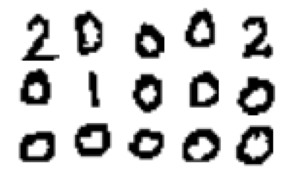

In [27]:
plt.figure(figsize=(5,3))
example_images = form_numbers
plot_digits(example_images, images_per_row=5)
plt.show()

In [28]:
Actual=np.array([2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

# Creating confusion matrix for evaluating test data:
from sklearn.metrics import confusion_matrix
Prediction = sgd_clf.predict(form_numbers)
confusion_matrix(Actual, Prediction)

array([[10,  0,  2],
       [ 0,  1,  0],
       [ 0,  0,  2]])

In [29]:
accuracy=sgd_clf.score(form_numbers,Actual)*100
print("This notebook has correctly identified {}% of digits".format(round(accuracy)))
print("Predicted Numbers =",Prediction)
print("Actual Numbers    =",Actual)

This notebook has correctly identified 87% of digits
Predicted Numbers = [2 0 2 0 2 0 1 0 0 2 0 0 0 0 0]
Actual Numbers    = [2 0 0 0 2 0 1 0 0 0 0 0 0 0 0]
